In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Dense, Input, Embedding, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [4]:
ads.shape

(799999, 3)

In [5]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799999 entries, 0 to 799998
Data columns (total 3 columns):
atitle     799999 non-null object
atext      799983 non-null object
adomain    799999 non-null object
dtypes: object(3)
memory usage: 18.3+ MB


In [6]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [7]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()

In [8]:
# remove punctuation from the ads text
ads['atext'] = ads['atext'].apply(punctuation_remover)

In [9]:
# remove punctuation from the ads text
ads['atitle'] = ads['atitle'].apply(punctuation_remover)

In [10]:
ads.nunique()

atitle     557981
atext      348409
adomain     19181
dtype: int64

In [11]:
(ads['atitle'] + ads['atext']).nunique()

789564

In [12]:
def text_parser_first(series): 
    series_copy = series.copy()
    list_of_strings = []
    for row in series:
        row= row.lower().strip()      
        list_of_strings.append(row)
    return list_of_strings

In [13]:
ads['atitle'] = text_parser_first(ads['atitle'])

In [14]:
ads['atext'] = text_parser_first(ads['atext'])

In [15]:
unique =ads.drop_duplicates(subset = ['atext'], keep=False)

In [16]:
unique =unique.drop_duplicates(subset = ['atitle'], keep=False)

In [17]:
unique = unique.drop_duplicates(keep=False)

In [18]:
unique.nunique()

atitle     192694
atext      192694
adomain      4465
dtype: int64

In [19]:
unique.shape

(192694, 3)

In [20]:
def text_parser_second(series): 
    series_copy = series.copy()
    list_of_strings = []
    for row in series:
        row= row.split()      
        list_of_strings.append(row)
    return list_of_strings

In [21]:
split_ads = unique.copy()

In [22]:
split_ads.shape

(192694, 3)

In [23]:
split_ads['atitle'] = text_parser_second(unique['atitle'])

In [24]:
split_ads['atext'] = text_parser_second(unique['atext'])

In [25]:
split_ads.head()

,atitle,atext,adomain
0,"[клуб, активного, отдыха, 0, 67]","[детский, пейнтбол, спортивный, пейнтбол, такт...",0-67.relax.by
1,"[антигравитационный, чехол, iphone, 5]","[успейте, купить, антигравитационный, чехол, д...",0-antigravity.ru
3,"[беспроцентный, заем, от, moneyveo]","[без, справок, получите, до, 3, 000, грн, на, ...",0-credit.moneyveo.ua
4,"[беспроцентный, заем, сотруднику]","[акция, получите, кредит, онлайн, под, 0%, без...",0-credit.moneyveo.ua
11,"[аnti, gravity, case]","[аnti, gravity, case, –, уникальный, антиграви...",0-gravity.online-shop-2017.ru


In [26]:
split_ads.iloc[10, 0]

['нужен', 'бухгалтер']

In [27]:
split_ads.iloc[10, 1]

['бухгалтер', 'под', 'ключ', 'дешево']

In [28]:
split_ads['combined'] = split_ads['atext'] +split_ads['atitle']

In [29]:
model_w2v = word2vec.Word2Vec(
    split_ads['combined'],
    workers=4,     
    min_count=30,   
    window=30,      
    sg=0,          
    sample=1e-3 ,  
    size=300,      
    hs=1           
)

In [30]:
vocabulary = model_w2v.wv.vocab.keys()
print(len(vocabulary))

8057


In [31]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 1000:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

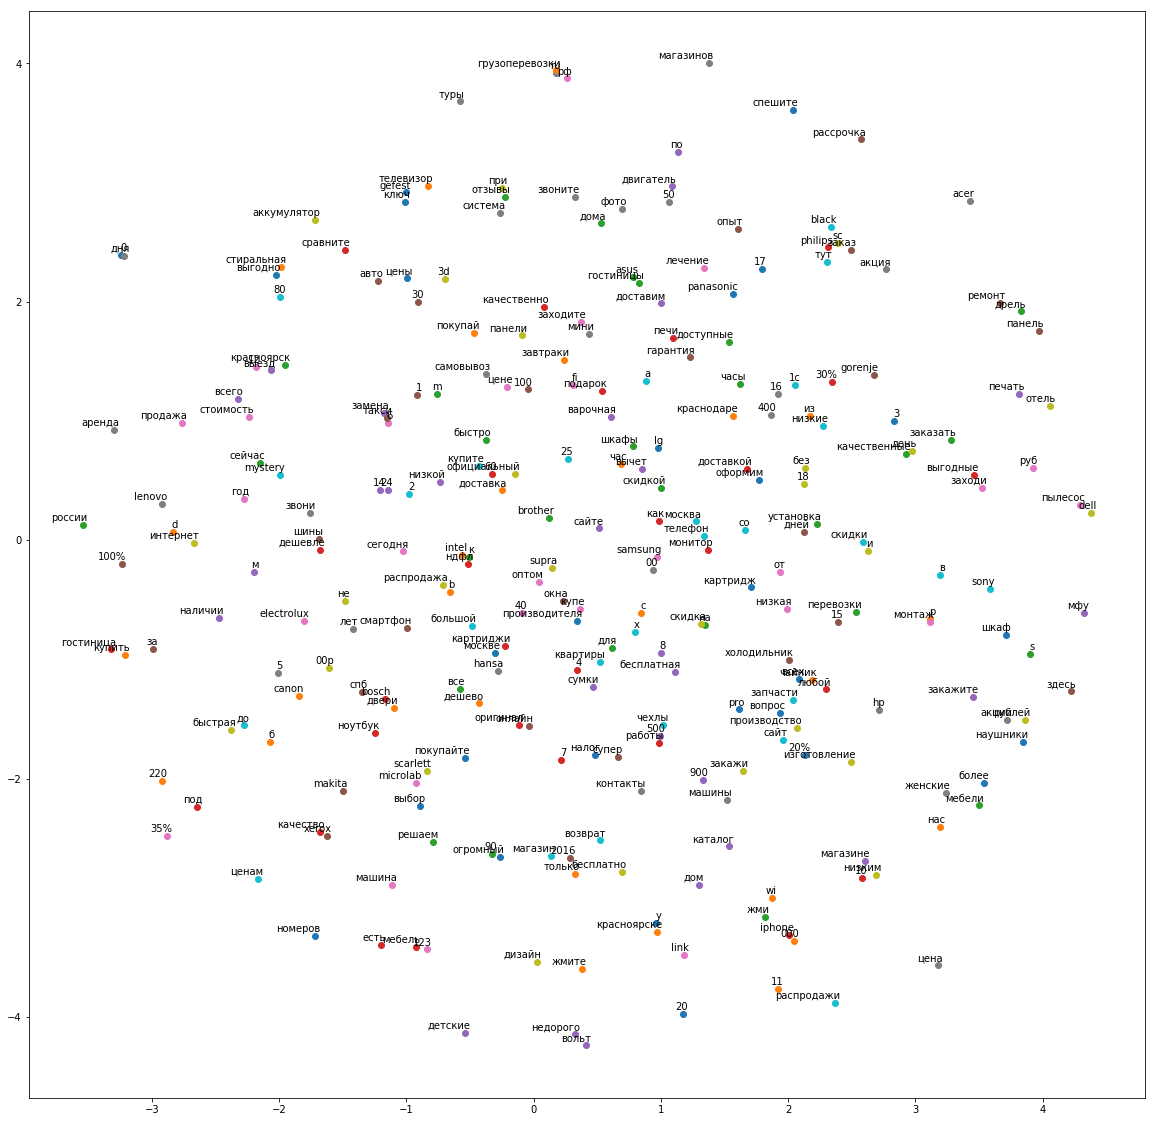

In [32]:
tsne_plot(model_w2v)

In [33]:
model_w2v.wv.most_similar_cosmul(positive=['компьютер'])

[('стабилизатор', 0.6141299605369568),
 ('ифнс', 0.6122391223907471),
 ('green', 0.605126678943634),
 ('отеля', 0.6034844517707825),
 ('покупке', 0.6017177700996399),
 ('подставки', 0.5986883044242859),
 ('перевезти', 0.5931029319763184),
 ('перфораторы', 0.592728853225708),
 ('379', 0.5925114750862122),
 ('подбор', 0.5905246734619141)]

In [36]:
model_w2v.wv.most_similar_cosmul(positive=['компьютер'])

[('компьютере', 0.6900703310966492),
 ('работает', 0.6674776673316956),
 ('починим', 0.665978193283081),
 ('16р', 0.6570090651512146),
 ('бухучета', 0.6556369662284851),
 ('ангар24', 0.6555264592170715),
 ('услуга', 0.6544506549835205),
 ('замена', 0.652470588684082),
 ('займ', 0.6524112224578857),
 ('настройки', 0.6516008973121643)]

In [37]:
word_vectors = model_w2v.wv

In [38]:
X = split_ads['atext']

In [39]:
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)

In [40]:
len(X_train)

134885

In [41]:
len(X_test)

57809

In [42]:
MAX_NB_WORDS = len(vocabulary)

In [43]:
MAX_NB_WORDS

8057

In [44]:
from collections import Counter
vocab=Counter()

for entry in X_train:
    vocab.update(entry)

In [45]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [46]:
training_sequences = [[word_index.get(t, 0) for t in ad_text]
             for ad_text in X_train]

In [47]:
test_sequences = [[word_index.get(t, 0) for t in ad_text]
             for ad_text in X_test]

In [48]:
max([len(x) for x in training_sequences])

22

In [49]:
max([len(x) for x in test_sequences])

20

In [50]:
MAX_SEQUENCE_LENGTH = max([len(x) for x in training_sequences])

In [51]:
def ngram_sequence_generator(input_text):
    ngram_inputs = []
    for entry in input_text:
        for i in range(1, len(entry)):
            ngram_seq = entry[:i+1]
            ngram_inputs.append(ngram_seq)
            
    return ngram_inputs

In [52]:
ngram_input_sequences_training = ngram_sequence_generator(training_sequences)

In [53]:
ngram_input_sequences_test = ngram_sequence_generator(test_sequences)

In [54]:
ngram_input_sequences_training[:20]

[[2382, 468],
 [2382, 468, 7],
 [2382, 468, 7, 1],
 [2382, 468, 7, 1, 5],
 [2382, 468, 7, 1, 5, 4],
 [2382, 468, 7, 1, 5, 4, 6],
 [4267, 135],
 [4267, 135, 118],
 [4267, 135, 118, 3295],
 [4267, 135, 118, 3295, 10],
 [4267, 135, 118, 3295, 10, 47],
 [4267, 135, 118, 3295, 10, 47, 208],
 [4267, 135, 118, 3295, 10, 47, 208, 198],
 [3, 207],
 [3, 207, 127],
 [3, 207, 127, 207],
 [3, 207, 127, 207, 0],
 [3, 207, 127, 207, 0, 0],
 [3, 207, 127, 207, 0, 0, 0],
 [3, 207, 127, 207, 0, 0, 0, 274]]

In [55]:
from keras.utils import to_categorical
def generate_padded_sequence(input_sequences):
    input_sequences = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
    

    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=MAX_NB_WORDS+1)
    return predictors, label

In [56]:
predictors_tr, label_tr = generate_padded_sequence(ngram_input_sequences_training)

KeyboardInterrupt: 

In [ ]:
predictors_test, label_test = generate_padded_sequence(ngram_input_sequences_test)

In [ ]:
len(predictors_tr)

In [ ]:
length_maxtrix = len(vocabulary)+1

embedding_matrix = np.zeros((length_maxtrix, 300))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
            continue
    try:        
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        if embedding_vector is not None:  
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [ ]:
embedding_matrix.shape

In [ ]:
WV_DIM = 300

In [ ]:
model_gen = Sequential()
model_gen.add(Embedding(MAX_NB_WORDS +1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH-1,
                     trainable=False))

model_gen.add(GRU(200))
model_gen.add(Dropout(0.2))
model_gen.add(BatchNormalization())
model_gen.add(Dense(MAX_NB_WORDS+1, activation = 'softmax'))

model_gen.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

In [ ]:
model_gen.fit(predictors_tr[:10000], label_tr[:10000], 
               epochs = 100, 
               verbose=1,
               batch_size=50,
               shuffle=True,
               validation_data = (predictors_test[:1000], label_test[:1000]))

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    output_sequence = ''
    for _ in range(next_words):
        seed_text = seed_text.lower()
        seed_list = seed_text.split()
        token_list = [word_index.get(word)for word in seed_list]
        token_list= pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding="pre")
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    for word in seed_list:
        output_sequence+=word+ ' '
    return output_sequence.strip()

In [ ]:
generate_text('с', 15, model_gen, 30)

In [ ]:
generate_text('двери', 10, model_gen, 30)

In [ ]:
model_gen_larger = Sequential()
model_gen_larger.add(Embedding(MAX_NB_WORDS +1,
                     WV_DIM,
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH-1,
                     trainable=False))

model_gen_larger.add(GRU(100, return_sequences=True))
model_gen_larger.add(Dropout(0.2))
model_gen_larger.add(GRU(100))
model_gen_larger.add(Dropout(0.2))
model_gen_larger.add(BatchNormalization())
model_gen_larger.add(Dense(MAX_NB_WORDS+1, activation = 'softmax'))

model_gen_larger.compile(loss='categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy']) 

In [ ]:
model_gen_larger.fit(predictors_tr[:200000], label_tr[:200000], 
               epochs = 30, 
               verbose=1,
               batch_size=30,
               shuffle=True,
               validation_data = (predictors_test[:1000], label_test[:1000]))

In [ ]:
generate_text('окна', 20, model_gen_larger, 15)

In [ ]:
generate_text('ноутбук', 20, model_gen_larger, 15)